# 07 — Threshold analysis (Gold)

Objectif : interpréter `y_pred ∈ [-1, +1]` comme **intensité de signal** (pas une probabilité),
puis évaluer la performance uniquement sur les prédictions fortes `|y_pred| > threshold`.


In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent  # notebook dans notebooks/
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

import numpy as np
import pandas as pd

from utils import get_logger
logger = get_logger("threshold_analysis", log_file=str(ROOT/"logs"/"threshold_analysis.log"))


## A) Charger les prédictions exportées (`outputs/gold_predictions.csv`)

In [13]:
pred_path = ROOT / "outputs" / "gold_predictions.csv"
if not pred_path.exists():
    logger.error("Fichier non trouvé: %s. Lance d'abord le notebook 05 pour générer outputs/gold_predictions.csv", pred_path)
else:
    df_pred = pd.read_csv(pred_path, parse_dates=["Date"])
    logger.info("Loaded %d rows from %s", len(df_pred), pred_path)
    df_pred.head()


2025-12-16 09:54:49,799 | INFO | threshold_analysis | Loaded 2217 rows from c:\Users\fayca\Downloads\hackathon_gold_project\hackathon_gold_project\outputs\gold_predictions.csv


## B) Appliquer un seuil (ex: 0.7)

In [18]:
threshold = 0.01

mask = df_pred["y_pred"].abs() > threshold
df_strong = df_pred.loc[mask].copy()

coverage = len(df_strong) / len(df_pred) if len(df_pred) else float("nan")
logger.info("Threshold=%.2f | strong signals=%d / %d (coverage=%.2f%%)",
            threshold, len(df_strong), len(df_pred), 100*coverage)

dir_acc_strong = (np.sign(df_strong["y_true"]) == np.sign(df_strong["y_pred"])).mean() if len(df_strong) else float("nan")
logger.info("Directional accuracy on strong signals: %.4f", dir_acc_strong)

df_strong[["Date","Close","y_true","y_pred"]].head()


2025-12-16 09:55:26,248 | INFO | threshold_analysis | Threshold=0.01 | strong signals=2176 / 2217 (coverage=98.15%)
2025-12-16 09:55:26,251 | INFO | threshold_analysis | Directional accuracy on strong signals: 0.5188


,Date,Close,y_true,y_pred
0,2010-05-27,1212.63,0.214568,0.120887
1,2010-05-28,1214.73,0.285527,0.226574
2,2010-05-31,1216.30,0.157655,0.218620
3,2010-06-01,1225.78,0.102264,0.185120
4,2010-06-02,1223.55,0.130347,0.353332


In [19]:
df_strong

,Date,Close,y_true,y_pred
0,2010-05-27,1212.63,0.214568,0.120887
1,2010-05-28,1214.73,0.285527,0.226574
2,2010-05-31,1216.30,0.157655,0.218620
3,2010-06-01,1225.78,0.102264,0.185120
4,2010-06-02,1223.55,0.130347,0.353332
...,...,...,...,...
2212,2018-11-27,1215.05,0.372864,0.192541
2213,2018-11-28,1221.23,0.318407,0.191189
2214,2018-11-29,1224.21,0.356306,0.175596
2215,2018-11-30,1220.52,0.417688,0.196683


## C) Courbe seuil vs couverture vs performance

In [9]:
from scipy.stats import spearmanr

thresholds = np.linspace(0.0, 0.95, 20)

rows = []
for t in thresholds:
    m = df_pred["y_pred"].abs() > t
    sub = df_pred.loc[m]
    if len(sub) < 25:
        continue
    coverage = len(sub) / len(df_pred)
    dir_acc = (np.sign(sub["y_true"]) == np.sign(sub["y_pred"])).mean()
    ic = spearmanr(sub["y_true"], sub["y_pred"]).correlation
    rows.append({"threshold": float(t), "coverage": float(coverage), "dir_acc": float(dir_acc), "ic": float(ic)})

df_curve = pd.DataFrame(rows).sort_values("threshold")
logger.info("Built curve with %d points", len(df_curve))
df_curve


2025-12-16 09:53:50,977 | INFO | threshold_analysis | Built curve with 10 points


,threshold,coverage,dir_acc,ic
0,0.00,1.000000,0.517366,0.034660
1,0.05,0.912945,0.508893,0.000331
2,0.10,0.839423,0.498119,0.007575
3,0.15,0.771313,0.495906,0.011378
4,0.20,0.613442,0.505882,-0.029957
5,0.25,0.467749,0.491803,-0.015243
6,0.30,0.305819,0.461652,0.089177
7,0.35,0.147497,0.492355,0.165779
8,0.40,0.035183,0.576923,0.378395
9,0.45,0.014434,0.625000,0.601027


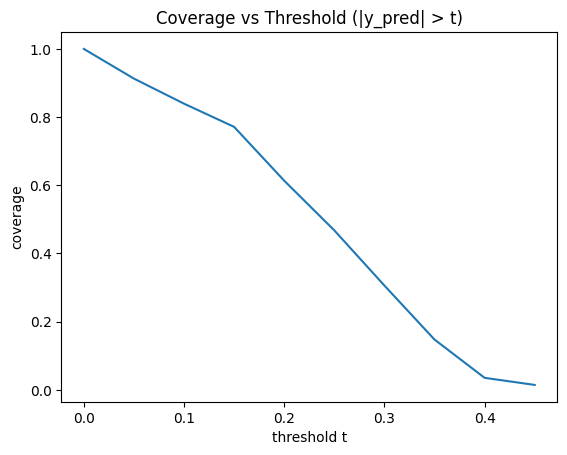

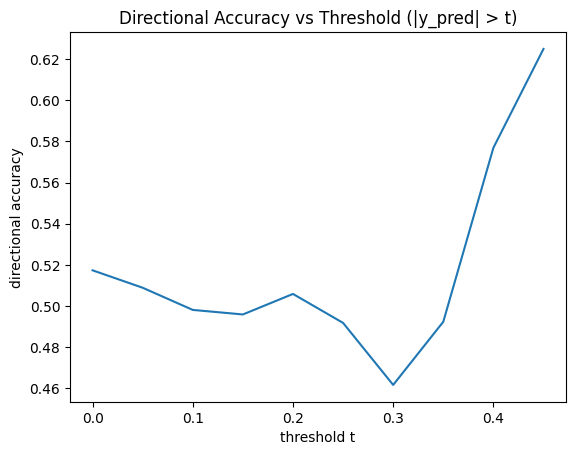

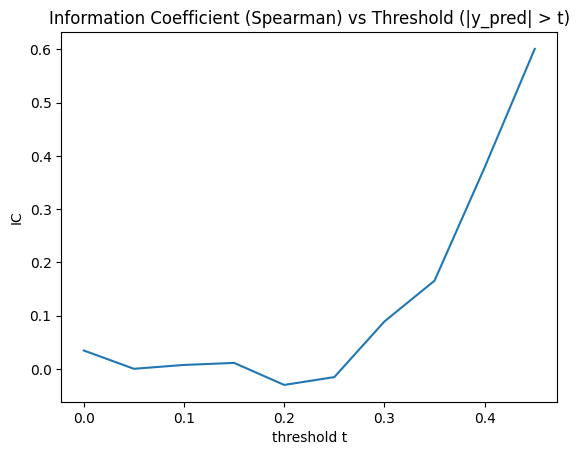

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_curve["threshold"], df_curve["coverage"])
plt.title("Coverage vs Threshold (|y_pred| > t)")
plt.xlabel("threshold t")
plt.ylabel("coverage")
plt.show()

plt.figure()
plt.plot(df_curve["threshold"], df_curve["dir_acc"])
plt.title("Directional Accuracy vs Threshold (|y_pred| > t)")
plt.xlabel("threshold t")
plt.ylabel("directional accuracy")
plt.show()

plt.figure()
plt.plot(df_curve["threshold"], df_curve["ic"])
plt.title("Information Coefficient (Spearman) vs Threshold (|y_pred| > t)")
plt.xlabel("threshold t")
plt.ylabel("IC")
plt.show()


## D) Mini stratégie proxy (long/short)

Proxy pédagogique : `position = sign(y_pred)` si `|y_pred| > t`, sinon 0.
PnL proxy = position * y_true (score).

In [11]:
t = 0.7
pos = np.where(df_pred["y_pred"].abs() > t, np.sign(df_pred["y_pred"]), 0.0)
pnl_proxy = pos * df_pred["y_true"].to_numpy()

df_bt = df_pred[["Date","Close","y_true","y_pred"]].copy()
df_bt["position"] = pos
df_bt["pnl_proxy"] = pnl_proxy
df_bt["cum_pnl_proxy"] = np.cumsum(np.nan_to_num(pnl_proxy))

logger.info("Proxy PnL: mean=%.6f | std=%.6f | sharpe_proxy=%.3f",
            np.mean(np.nan_to_num(pnl_proxy)),
            np.std(np.nan_to_num(pnl_proxy)),
            (np.mean(np.nan_to_num(pnl_proxy)) / (np.std(np.nan_to_num(pnl_proxy)) + 1e-12)))

df_bt.head()


2025-12-16 09:54:17,343 | INFO | threshold_analysis | Proxy PnL: mean=0.001141 | std=0.032051 | sharpe_proxy=0.036


,Date,Close,y_true,y_pred,position,pnl_proxy,cum_pnl_proxy
0,2010-05-27,1212.63,0.214568,0.120887,0.0,0.0,0.0
1,2010-05-28,1214.73,0.285527,0.226574,0.0,0.0,0.0
2,2010-05-31,1216.30,0.157655,0.218620,0.0,0.0,0.0
3,2010-06-01,1225.78,0.102264,0.185120,0.0,0.0,0.0
4,2010-06-02,1223.55,0.130347,0.353332,0.0,0.0,0.0


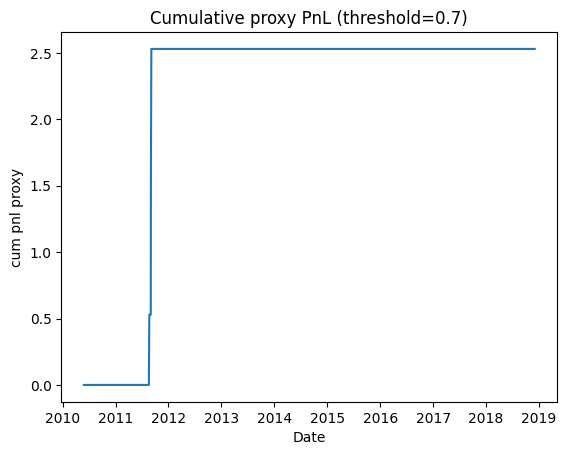

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_bt["Date"], df_bt["cum_pnl_proxy"])
plt.title(f"Cumulative proxy PnL (threshold={t})")
plt.xlabel("Date")
plt.ylabel("cum pnl proxy")
plt.show()


## Notes soutenance
- `y_pred` est une intensité de signal, pas une probabilité.
- Un seuil améliore souvent la qualité au prix d'une couverture plus faible.
